In [3]:
import pandas as pd
from sqlalchemy import create_engine
# Replace these values with your actual database information
hostname = "gator3228.hostgator.com"
username = "rbrennan_sm_bcd"
password = "This_is_not_the_password"
database = "rbrennan_stock_project_4"
# Create a database connection
db_url = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{database}"
engine = create_engine(db_url)
# Test the connection
try:
    conn = engine.connect()
    print("Connected to MySQL database")
except Exception as e:
    print("Error:", e)
amzn_data = pd.read_sql("SELECT * FROM Amazon", conn)
amzn_data

Connected to MySQL database


,Date,Open,High,Low,Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,99100000
...,...,...,...,...,...,...
1399,2023-09-12,142.320007,143.000000,140.610001,141.229996,42668500
1400,2023-09-13,140.949997,144.979996,140.869995,144.850006,60465200
1401,2023-09-14,145.080002,145.860001,142.949997,144.720001,64033600
1402,2023-09-15,142.690002,143.570007,140.089996,140.389999,102861700


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
for dirname, _, filenames in os.walk('./archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')

In [5]:
amzn_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [12]:
missing_values = amzn_data.isnull().sum()
print(missing_values)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [11]:
amzn_info = amzn_data.info
print(amzn_info)

<bound method DataFrame.info of            Date        Open        High         Low       Close     Volume
0    2018-02-20   72.324501   74.438499   72.324501   73.417503  129984000
1    2018-02-21   74.250000   75.174500   73.945999   74.146004  126088000
2    2018-02-22   74.767998   75.126999   73.788002   74.266998   97162000
3    2018-02-23   74.766998   75.000000   74.324997   75.000000   88362000
4    2018-02-26   75.459999   76.141998   75.349998   76.097504   99100000
...         ...         ...         ...         ...         ...        ...
1399 2023-09-12  142.320007  143.000000  140.610001  141.229996   42668500
1400 2023-09-13  140.949997  144.979996  140.869995  144.850006   60465200
1401 2023-09-14  145.080002  145.860001  142.949997  144.720001   64033600
1402 2023-09-15  142.690002  143.570007  140.089996  140.389999  102861700
1403 2023-09-18  140.479996  141.750000  139.220001  139.979996   42823500

[1404 rows x 6 columns]>


In [14]:
summary_stats = amzn_data.describe().T
print(summary_stats)

         count          mean           std           min           25%  \
Open    1404.0  1.204012e+02  3.339273e+01  6.730000e+01  9.099237e+01   
High    1404.0  1.218659e+02  3.373689e+01  6.980150e+01  9.166037e+01   
Low     1404.0  1.188021e+02  3.299514e+01  6.535000e+01  9.000875e+01   
Close   1404.0  1.203472e+02  3.332554e+01  6.719800e+01  9.087063e+01   
Volume  1404.0  8.262410e+07  3.887208e+07  1.762600e+07  5.643655e+07   

                 50%           75%           max  
Open    1.112000e+02  1.563623e+02  1.872000e+02  
High    1.139113e+02  1.583836e+02  1.886540e+02  
Low     1.086100e+02  1.543006e+02  1.848395e+02  
Close   1.111387e+02  1.558640e+02  1.865705e+02  
Volume  7.130300e+07  9.760650e+07  3.113460e+08  


In [15]:
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])

<Axes: >

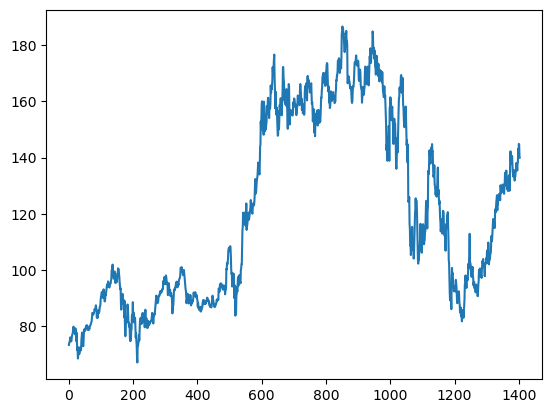

In [16]:
amzn_data['Close'].plot()

In [17]:

amzn_data['50_day_MA'] = amzn_data['Close'].rolling(window=50).mean()

In [18]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

amzn_data['RSI'] = calculate_rsi(amzn_data)

In [21]:
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Volume', '50_day_MA']
target = 'Close'

# Split data into train and test sets
train_data, test_data = train_test_split(amzn_data, test_size=0.2, shuffle=False)

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
arima_model =ARIMA(train_data[target], order=(5, 1, 1))

# Fit the ARIMA model
arima_fit = arima_model.fit()

In [26]:
from sklearn.metrics import mean_squared_error

predictions = arima_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data[target], predictions)
print(mse)

1160.1154024362775


Text(0.5, 1.0, 'Actual vs. Predicted Prices')

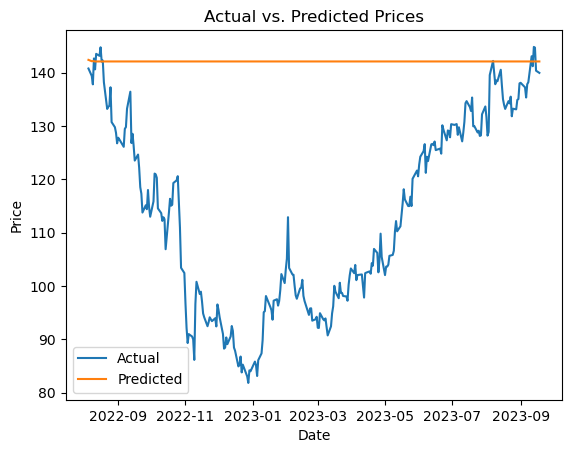

In [27]:
plt.plot(test_data['Date'], test_data[target], label='Actual')   
plt.plot(test_data['Date'], predictions, label='Predicted')      
plt.legend()                                                     
plt.xlabel('Date')                                             
plt.ylabel('Price')                                       
plt.title('Actual vs. Predicted Prices')                 

In [28]:
# Use the trained model to predict future prices
# Generate a range of dates for future predictions
future_dates = pd.date_range(start=test_data['Date'].iloc[-1], periods=30, freq='D')
# Create a DataFrame to store future prediction dates
future = pd.DataFrame({'ds': future_dates})

In [31]:
import xgboost as xgb

# Define features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Volume', '50_day_MA']
target = 'Close'

# Create DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(data=train_data[features], label=train_data[target])

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.01
}

# Train the XGBoost model
xgb_model = xgb.train(params=params, dtrain=train_dmatrix)

In [32]:
test_dmatrix = xgb.DMatrix(data=test_data[features], label=test_data[target])

# Use the trained XGBoost model to make predictions
xgb_predictions = xgb_model.predict(test_dmatrix)

# Calculate Mean Squared Error
mse_xgb = mean_squared_error(test_data[target], xgb_predictions)
print(mse_xgb)

326.35022977509453


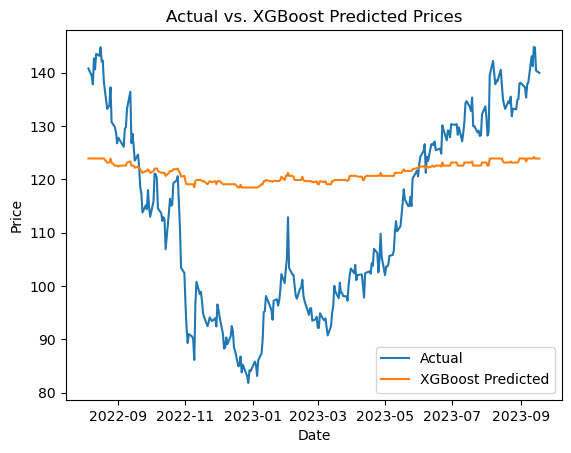

In [33]:
plt.plot(test_data['Date'], test_data[target], label='Actual')
plt.plot(test_data['Date'], xgb_predictions, label='XGBoost Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. XGBoost Predicted Prices')
plt.show()